<a href="https://colab.research.google.com/github/Camouflage10/disease-spread-model/blob/Camouflage10-bagging/disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sn
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold


In [ ]:
minCorr=.2
kfoldruns=10

In [ ]:
def getData():
  x = pd.read_csv('train_x.csv')
  y = pd.read_csv('dengue_labels_train.csv')
  y=y.drop(columns=['city','year','weekofyear'])
  test =pd.read_csv('test.csv')


  x['year']=x['year'].astype(int)
  x['city'].replace(['sj', 'iq'],[0, 1], inplace=True)
  x[['year2', 'month', 'day']] = x['week_start_date'].str.split('-', expand=True)
  x['month']=x['month'].astype(int)
  x['day']=x['day'].astype(int)
  x=x.drop(columns=['year2','week_start_date'])
  
  test['year']=test['year'].astype(int)
  test['city'].replace(['sj', 'iq'],[0, 1], inplace=True)
  test[['year2', 'month', 'day']] = test['week_start_date'].str.split('-', expand=True)
  test['month']=test['month'].astype(int)
  test['day']=test['day'].astype(int)
  test=test.drop(columns=['year2','week_start_date'])

  return x, y, test

In [ ]:
#tremove features with a corrilation of less than abs(mincorr)
def removeFeatures(x,y,test,minCorr):
  x['total_cases']=y['total_cases']
  corrMatrix = x.corr()
  lastCol=corrMatrix['total_cases']
  x=x.drop(columns=['total_cases'])
  print(lastCol)
  features=list(lastCol.loc[abs(lastCol) > minCorr].index)
  features.remove('total_cases')
  x=x[features]
  test=test[features]
  corrMatrix = x.corr()
  print(len(x.columns))
  return x,test

In [ ]:
def getParams(x_train, y_train, model, hyperbag):
  model = model()
  #Applying GridSearchCV to get the best value for hyperparameters
  gridbag = GridSearchCV(model, hyperbag, scoring='neg_mean_absolute_error', cv = 2, verbose = 1, n_jobs = -1)
  gridbag.fit(x_train, y_train)
  print(gridbag.best_params_)
  return gridbag.best_params_, pd.DataFrame(gridbag.cv_results_)

In [ ]:

def getPreds(x_train, x_test, y_train, y_test, model):
  temp=sklearn.base.clone(model)
  temp.fit(x_train,y_train)
  preds = temp.predict(x_test)
  preds=[round(num) for num in preds]
  rmse = np.sqrt(mean_squared_error(y_test, preds))

  #MSE and RMSE
  mse = mean_squared_error(y_test, preds)
  print("MSE: %.2f" % mse)
  rmse = np.sqrt(mean_squared_error(y_test, preds))
  mae= mean_absolute_error(y_test,preds)
  print("RMSE: %f" % (rmse))
  print("MaE: %f" % (mae))
  bag2=sklearn.base.clone(bag)
  #accuracy score round preds
  round_preds=[round(num) for num in preds]
  accuracy = accuracy_score(y_test, round_preds)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  return temp,preds

In [ ]:
#K-Fold cross-val
from sklearn.model_selection import RepeatedKFold
def kFoldValues(x,y,model,n):
  rkf = RepeatedKFold(n_splits=2, n_repeats=n)
  bagMae=[]
  for train_index, test_index in rkf.split(x,y):
    x_traint, x_testt= x.iloc[train_index], x.iloc[test_index]
    y_traint, y_testt =y.iloc[train_index], y.iloc[test_index]
    temp=sklearn.base.clone(model)
    temp.fit(x_traint,y_traint)
    preds = temp.predict(x_testt)
    mae= mean_absolute_error(y_testt,preds)
    bagMae.append(mae)

  bagMae=np.array(bagMae)
  print(bagMae)
  #sd and mean of mae
  return np.std(bagMae), np.mean(bagMae)


In [ ]:
x,y,test=getData()
x,test=removeFeatures(x,y,test,minCorr)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737


In [ ]:
#grid search
hyperbag={'n_estimators': [75,85,90],'max_features':[4,5]}
bagparam, bagResults=getParams(x_train, y_train, BaggingRegressor, hyperbag)
bagResults.iloc[: , 6:]

Fitting 2 folds for each of 6 candidates, totalling 12 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 4, 'n_estimators': 85}


,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'max_features': 4, 'n_estimators': 75}",-16.467127,-14.754856,-15.610991,0.856136,6
1,"{'max_features': 4, 'n_estimators': 85}",-14.159165,-14.184134,-14.171649,0.012484,1
2,"{'max_features': 4, 'n_estimators': 90}",-15.887087,-14.740289,-15.313688,0.573399,5
3,"{'max_features': 5, 'n_estimators': 75}",-15.129030,-13.573078,-14.351054,0.777976,2
4,"{'max_features': 5, 'n_estimators': 85}",-15.062175,-13.859158,-14.460666,0.601508,3
5,"{'max_features': 5, 'n_estimators': 90}",-14.691177,-14.270907,-14.481042,0.210135,4


In [ ]:
hyperbag={'n_estimators': [75,85,175],'max_features':[4,5,6]}
forestparam, forestResults=getParams(x_train, y_train, RandomForestRegressor, hyperbag)
forestResults.iloc[: , 6:]

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 5, 'n_estimators': 175}


,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'max_features': 4, 'n_estimators': 75}",-15.352104,-13.120767,-14.236435,1.115669,3
1,"{'max_features': 4, 'n_estimators': 85}",-15.261017,-13.582123,-14.421570,0.839447,7
2,"{'max_features': 4, 'n_estimators': 175}",-15.193009,-13.507328,-14.350169,0.842841,5
3,"{'max_features': 5, 'n_estimators': 75}",-15.666311,-13.136619,-14.401465,1.264846,6
4,"{'max_features': 5, 'n_estimators': 85}",-15.253351,-13.130281,-14.191816,1.061535,2
5,"{'max_features': 5, 'n_estimators': 175}",-14.804906,-13.378434,-14.091670,0.713236,1
6,"{'max_features': 6, 'n_estimators': 75}",-15.461202,-13.534511,-14.497856,0.963346,8
7,"{'max_features': 6, 'n_estimators': 85}",-15.361500,-13.287160,-14.324330,1.037170,4
8,"{'max_features': 6, 'n_estimators': 175}",-15.678724,-13.497507,-14.588115,1.090609,9


In [ ]:
bag = BaggingRegressor(n_estimators=bagparam['n_estimators'],
                       max_features= bagparam['max_features'])
forest=RandomForestRegressor(max_features=forestparam['max_features'],
                             n_estimators=forestparam['n_estimators'])

In [ ]:
bagModel, bagpreds=getPreds(x_train, x_test, y_train, y_test, bag)
forestModel, forestpreds=getPreds(x_train, x_test, y_train, y_test, forest)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


MSE: 502.26
RMSE: 22.411202
MaE: 10.844075
Accuracy: 5.61%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


MSE: 397.10
RMSE: 19.927363
MaE: 10.347193
Accuracy: 6.44%


In [ ]:
#K-Fold cross-val

bagstd, bagmean=kFoldValues(x,y,bag, kfoldruns)
foreststd, forestmean=kFoldValues(x,y,forest, kfoldruns)
print('bag')
print("std: "+str(bagstd))
print("mean: "+str(bagmean))
print('forest')
print("std: "+str(foreststd))
print("mean: "+str(forestmean))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[13.38552844 12.4805214  12.36110213 13.62320328 11.62207498 14.94870718
 13.30234324 13.26769285 13.093591   13.46848739 12.85861614 14.43705559
 13.27962185 13.04119302 12.08765152 14.44605688 12.95803975 13.46935009
 12.31276665 12.89896035]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[13.44163004 12.78153846 13.11397436 12.13029304 10.64606227 14.54791209
 11.78419414 12.8614652  14.53619048 11.79703297 13.07254579 12.31424908
 13.70102564 11.47119048 13.35587912 12.13142857 12.28663004 12.74871795
 11.76992674 14.19732601]
bag
std: 0.791735010482817
mean: 13.167128187172304
forest
std: 1.0135913657273818
mean: 12.734460622710623


In [ ]:
#create metrics.json (optional metrics.txt also)
value = {
        "bag_mae_std": bagstd,
        "bag_mae_mean": bagmean,
        "forest_mae_std": foreststd,
        "forest_mae_mean": forestmean
    }
with open('metrics.json', 'w') as outfile:
  outfile.write(json.dumps(value))

In [ ]:
bagpreds=np.array(bagpreds)
forestpreds=np.array(forestpreds)

y_test=np.array(y_test)
y_test=y_test.reshape(bagpreds.shape)

bagerror=y_test-bagpreds
foresterror=y_test-forestpreds

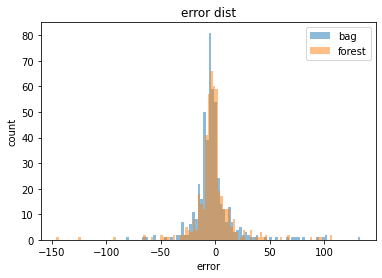

In [ ]:
#visualization to see if it looks like it matches

#error=error.reshape(error.shape[0]*error.shape[1],1)
x_ax = range(len(y_test))
plt.tight_layout()
fig1 = plt.gcf()
plt.hist(bagerror, bins='auto', alpha=.5, label='bag')
plt.hist(foresterror, bins='auto', alpha=.5, label='forest')
plt.title('error dist')
plt.xlabel('error')
plt.ylabel('count')
plt.legend()
plt.show()

#create a graph called stats.png
fig1.savefig('stats.png', dpi=100)

In [ ]:
from pyparsing import results
testmincorr=[.1,.15,.2,.22,.24]
col=["mincorr","#features","bag_mae_std", "bag_mae_mean", "forest_mae_std", "forest_mae_mean"]
df=pd.DataFrame(columns=col)
bags=[]
forests=[]
for n in testmincorr:
  x,y,test1=getData()
  x, test1=removeFeatures(x,y,test,n)
  features=int(len(x.columns))
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
  hyperbag={'n_estimators': [75,85,90],'max_features':[4,5]}
  bagparam,results=getParams(x_train, y_train, BaggingRegressor, hyperbag)
  hyperbag={'n_estimators': [75,85,175],'max_features':[4,5,6]}
  forestparam, results=getParams(x_train, y_train, RandomForestRegressor, hyperbag)
  bag = BaggingRegressor(n_estimators=bagparam['n_estimators'],
                       max_features= bagparam['max_features'])
  forest=RandomForestRegressor(max_features=forestparam['max_features'],
                             n_estimators=forestparam['n_estimators'])
  bagstd, bagmean=kFoldValues(x,y,bag, kfoldruns)
  foreststd, forestmean=kFoldValues(x,y,forest, kfoldruns)
  df.loc[len(df)]=[n,features,bagstd,bagmean,foreststd,forestmean]
print(bagparams)
print(forestparams)
df

Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
station_diur_temp_rng_c                 -0.235323
station_min_temp_c                       0.259204
city                                    -0.292624
year                                    -0.306806
month                                    0.215737


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 4, 'n_estimators': 85}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 6, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[16.58031162 14.22746329 16.21513965 14.88053571 17.01979099 14.3724419
 14.94118301 13.89396143 16.36642696 15.80861564 16.98962864 15.70905294
 16.80545603 14.68460326 14.54217868 16.09190746 16.63349224 14.54445567
 16.8584707  14.82221754]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[12.53485348 14.05089744 13.44705128 13.6093956  13.07672161 15.35346154
 12.60305861 13.91877289 14.43051282 12.42912088 14.35260073 14.02261905
 13.91540293 14.80322344 14.17487179 15.41410256 13.38598901 13.21998168
 12.59208791 14.64307692]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 90}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 5, 'n_estimators': 85}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[13.40380647 13.09303342 13.13917125 13.81230762 13.46225843 14.58971306
 12.97579925 13.82016255 12.69275997 13.50149445 12.58160358 14.97021889
 13.53657407 14.25449263 13.37598298 12.6123054  13.5540293  12.21597004
 13.624585   14.50662975]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[11.45292502 14.39683258 12.79001293 13.78115708 12.6593245  12.93299935
 13.86132838 12.56616031 13.7083064  13.63826761 13.43073691 11.74355204
 13.7022786  12.5039108  13.51116677 13.31871364 13.38403361 14.46869748
 12.76184551 13.63807369]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 85}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 5, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[11.31846854 14.11568531 13.14606941 11.99864253 13.32055545 12.92545249
 13.10698395 12.100376   13.10445755 12.97922323 12.95129757 12.99734971
 13.01621995 12.59204913 13.53443762 13.57460003 12.23915266 14.09926944
 13.72199688 11.73520524]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[12.8389011  12.58131868 13.00225275 12.64587912 14.13778388 12.29699634
 12.71492674 13.1779304  13.60485348 11.77021978 12.43384615 12.02485348
 13.1825641  12.41038462 13.1635348  12.80846154 13.88871795 12.57967033
 13.25644689 12.36184982]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 4, 'n_estimators': 75}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 4, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[13.40673382 13.40303571 13.66460653 14.20631755 13.57027656 11.73481166
 12.81652015 14.4529304  13.87932845 13.14396477 14.34149267 13.5399076
 14.02138198 14.85089011 13.53686259 14.09207433 12.22427381 14.89489713
 14.5433486  13.50800061]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[13.3417033  14.35238095 13.21807692 15.50593407 14.04302198 13.80882784
 13.91483516 13.29410256 14.97111722 12.94371795 13.02567766 13.34637363
 13.57661172 13.16203297 13.23688645 14.85238095 13.81532967 13.45432234
 13.87624542 13.98150183]
Unnamed: 0                              -0.333340
weekofyear                               0.216452
ndvi_ne                                 -0.210937
ndvi_nw                                 -0.184179
ndvi_se                                 -0.232385
ndvi_sw                                 -0.249576
reanalysis_air_temp_k                    0.258385
reanalysis_avg_temp_k                    0.146057
reanalysis_dew_point_temp_k              0.135880
reanalysis_max_air_temp_k               -0.190789
reanalysis_min_air_temp_k                0.318676
reanalysis_relative_humidity_percent    -0.132312
reanalysis_specific_humidity_g_per_kg    0.124578
reanalysis_tdtr_k                       -0.278156
station_avg_temp_c                       0.113804
stati

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


{'max_features': 5, 'n_estimators': 75}
Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_features': 5, 'n_estimators': 75}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

[10.78187729 12.85032967 12.71289377 12.77818376 13.73662088 11.74210714
 15.86431502 10.78705128 10.90459707 13.94602686 12.55503297 12.14943223
 13.06640568 13.09569902 12.3260989  11.3721978  12.10575092 12.10175824
 12.45775031 12.19964286]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

[14.02269231 12.95518315 12.69230769 11.87877289 13.20173993 11.31373626
 13.23935897 12.57782051 13.75721612 12.34521978 11.47641026 13.8242674
 12.60045788 11.82054945 14.28820513 11.92428571 12.60857143 12.30824176
 13.16018315 12.5253663 ]
[{'max_features': 4, 'n_estimators': 85}, {'max_features': 5, 'n_estimators': 90}, {'max_features': 5, 'n_estimators': 85}, {'max_features': 4, 'n_estimators': 75}, {'max_features': 5, 'n_estimators': 75}]
[{'max_features': 6, 'n_estimators': 75}, {'max_features': 5, 'n_estimators': 85}, {'max_features': 5, 'n_estimators': 75}, {'max_features': 4, 'n_estimators': 75}, {'max_features': 5, 'n_estimators': 75}]


,mincorr,#features,bag_mae_std,bag_mae_mean,forest_mae_std,forest_mae_mean
0,0.10,20.0,1.029687,15.599367,0.874147,13.798890
1,0.15,15.0,0.695559,13.486145,0.764530,13.212516
2,0.20,13.0,0.728997,12.928875,0.582049,12.844070
3,0.22,10.0,0.787303,13.691583,0.672252,13.786054
4,0.24,8.0,1.155185,12.476689,0.814591,12.726029


In [ ]:
#get model of best metrics to predict test

In [ ]:
#submit predictions fo test
x,y,test1=getData()
x, test1=removeFeatures(x,y,test,n)
#first convert float array to int
pred = forestModel.predict(test)
pred=[int(round(num)) for num in pred]
test_original =pd.read_csv('dengue_features_test.csv')
#then make data frame for predicted data
submission=pd.DataFrame()
submission[['city', 'year', 'weekofyear']]=test_original[['city', 'year', 'weekofyear']]
submission['total_cases']=pred
#submission.sort_values(["city","year","weekofyear"],axis=0, ascending=True, inplace=True, na_position='first')
submission.to_csv('submission.csv', index=False)